# Import Libraries

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
import torchvision
from torch.utils.data import Dataset, DataLoader

# KAN library
from kan_convolutional.KANConv import KAN_Convolutional_Layer
from kan_convolutional.KANLinear import KANLinear

import optuna

In [3]:
# device
print(torch.cuda.is_available())
print('device name:', torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def print_gpu_memory():
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# Free up GPU memory
# torch.cuda.empty_cache()

print_gpu_memory()

True
device name: NVIDIA GeForce RTX 3050 Laptop GPU
Allocated memory: 0.00 MB
Cached memory: 0.00 MB


# RGB Model

In [3]:
# hyperparameters
in_channels = 3
num_classes = 3
batch_size = 32

## Load Dataset

In [4]:
class DrowningDataset(Dataset):
    def __init__(self, csv_file, split, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations = self.annotations[self.annotations['file_path'].str.contains(rf'\\{split}\\|/{split}/', regex=True)]
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = self.annotations.iloc[index, 0]

        # Use PIL to open image
        image = Image.open(img_path).convert("RGB")  
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return image, y_label


In [5]:
# Define transformations for training with augmentations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define transformations for validation (no augmentations)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_ds = DrowningDataset(csv_file = 'drowning_dataset_32.csv', split = 'train', transform = train_transform)
val_ds = DrowningDataset(csv_file = 'drowning_dataset_32.csv', split = 'val', transform = val_transform)

train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False)

dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)

torch.Size([32, 3, 32, 32])


## Define Model

In [12]:
class KAN_RGB(nn.Module):
    def __init__(self, grid_size: int = 5):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(in_channels=3,
            out_channels= 6,
            kernel_size= (5,5),
            grid_size = grid_size,
            padding =(0,0)
        )

        self.conv2 = KAN_Convolutional_Layer(in_channels=6,
            out_channels= 16,
            kernel_size = (5,5),
            grid_size = grid_size,
            padding =(0,0)
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )
        
        self.flat = nn.Flatten() 

        self.kan1 = KANLinear(
            400,
            3,
            grid_size=grid_size,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0,1],
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.pool1(x)
        
        x = self.flat(x)
        x = self.kan1(x)

        return x

In [13]:
model = KAN_RGB()

## Training Loop

In [9]:
# See total number of params
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Params start",count_parameters(model))

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
precisions = []
recalls = []
f1_scores = []

# Variables to track the best model
best_val_acc = 0.0
best_epoch = 0
best_metrics = {}

start = time.perf_counter()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(val_loader)):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())    # Store actual labels
            
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Normalize test loss
    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Compute precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # Store metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

    
    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_metrics = {
            "epoch": best_epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
        }

        torch.save(model.state_dict(), "kan_rgb_model.pth")

total_time = time.perf_counter() - start

model.training_time = total_time/60 /num_epochs
print("\nTraining complete! ✅")
print(f"Total time (min) {total_time/60:.2f}",)
print("\nBest Model Summary:")
print(f"Epoch: {best_metrics['epoch']}")
print(f"Train Loss: {best_metrics['train_loss']:.4f}, Train Acc: {best_metrics['train_acc']:.2f}%")
print(f"Val Loss: {best_metrics['val_loss']:.4f}, Val Acc: {best_metrics['val_acc']:.2f}%")
print(f"Precision: {best_metrics['precision']:.2f}, Recall: {best_metrics['recall']:.2f}, F1 Score: {best_metrics['f1_score']:.2f}")

Params start 40500


100%|██████████| 114/114 [00:51<00:00,  2.20it/s]


Epoch [1/10] - Train Loss: 0.5435, Train Acc: 77.66%
Val loss: 0.2340, Val Acc: 92.34%, Precision: 0.92, Recall: 0.92, F1 Score: 0.92


100%|██████████| 114/114 [00:53<00:00,  2.15it/s]


Epoch [2/10] - Train Loss: 0.3064, Train Acc: 89.19%
Val loss: 0.1572, Val Acc: 95.08%, Precision: 0.95, Recall: 0.95, F1 Score: 0.95


100%|██████████| 114/114 [00:53<00:00,  2.15it/s]


Epoch [3/10] - Train Loss: 0.2475, Train Acc: 91.46%
Val loss: 0.1167, Val Acc: 96.13%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:53<00:00,  2.14it/s]


Epoch [4/10] - Train Loss: 0.2295, Train Acc: 92.30%
Val loss: 0.1085, Val Acc: 96.43%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:52<00:00,  2.17it/s]


Epoch [5/10] - Train Loss: 0.2086, Train Acc: 92.89%
Val loss: 0.1038, Val Acc: 96.85%, Precision: 0.97, Recall: 0.97, F1 Score: 0.97


100%|██████████| 114/114 [00:53<00:00,  2.14it/s]


Epoch [6/10] - Train Loss: 0.2013, Train Acc: 93.32%
Val loss: 0.1050, Val Acc: 96.85%, Precision: 0.97, Recall: 0.97, F1 Score: 0.97


100%|██████████| 114/114 [00:59<00:00,  1.93it/s]


Epoch [7/10] - Train Loss: 0.1969, Train Acc: 93.31%
Val loss: 0.0950, Val Acc: 97.24%, Precision: 0.97, Recall: 0.97, F1 Score: 0.97


100%|██████████| 114/114 [01:01<00:00,  1.85it/s]


Epoch [8/10] - Train Loss: 0.1849, Train Acc: 93.77%
Val loss: 0.0871, Val Acc: 97.37%, Precision: 0.97, Recall: 0.97, F1 Score: 0.97


100%|██████████| 114/114 [00:40<00:00,  2.80it/s]


Epoch [9/10] - Train Loss: 0.1777, Train Acc: 93.89%
Val loss: 0.0934, Val Acc: 97.21%, Precision: 0.97, Recall: 0.97, F1 Score: 0.97


100%|██████████| 114/114 [00:40<00:00,  2.84it/s]

Epoch [10/10] - Train Loss: 0.1776, Train Acc: 94.07%
Val loss: 0.0937, Val Acc: 97.04%, Precision: 0.97, Recall: 0.97, F1 Score: 0.97

Training complete! ✅
Total time (min) 83.11

Best Model Summary:
Epoch: 8
Train Loss: 0.1849, Train Acc: 93.77%
Val Loss: 0.0871, Val Acc: 97.37%
Precision: 0.97, Recall: 0.97, F1 Score: 0.97


In [10]:
# Save metrics to a CSV file
metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies,
    "precisions": precisions,
    "recalls": recalls,
    "f1_scores": f1_scores,
}
df = pd.DataFrame(metrics)
df.to_csv("kan_rgb_training_metrics.csv", index=False)

print("Metrics saved as 'kan_rgb_training_metrics.csv'")

Metrics saved as 'kan_rgb_training_metrics.csv'


# Grayscale Model

In [3]:
# hyperparameters
in_channels = 1
num_classes = 3
batch_size = 32

## Load Dataset

In [4]:
class DrowningDataset(Dataset):
    def __init__(self, csv_file, split, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations = self.annotations[self.annotations['file_path'].str.contains(rf'\\{split}\\|/{split}/', regex=True)]
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = self.annotations.iloc[index, 0]

        # Use PIL to open image
        image = Image.open(img_path).convert("L")  
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return image, y_label

In [5]:
# Define transformations for training with augmentations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Grayscale Normalization
])

# Define transformations for validation (no augmentations)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Grayscale Normalization
])

train_ds = DrowningDataset(csv_file = 'drowning_dataset_32.csv', split = 'train', transform = train_transform)
val_ds = DrowningDataset(csv_file = 'drowning_dataset_32.csv', split = 'val', transform = val_transform)

train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False)

dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)

torch.Size([32, 1, 32, 32])


## Define Model

In [7]:
class KAN_Grayscale(nn.Module):
    def __init__(self, grid_size: int = 5):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(in_channels=1,
            out_channels= 6,
            kernel_size= (5,5),
            grid_size = grid_size,
            padding =(0,0)
        )

        self.conv2 = KAN_Convolutional_Layer(in_channels=6,
            out_channels= 16,
            kernel_size = (5,5),
            grid_size = grid_size,
            padding =(0,0)
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )
        
        self.flat = nn.Flatten() 

        self.kan1 = KANLinear(
            400,
            3,
            grid_size=grid_size,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0,1],
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.pool1(x)
        
        x = self.flat(x)
        x = self.kan1(x)

        return x

In [8]:
model = KAN_Grayscale()

## Create and Train Model

In [9]:
# See total number of params
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Params start",count_parameters(model))

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
precisions = []
recalls = []
f1_scores = []

# Variables to track the best model
best_val_acc = 0.0
best_epoch = 0
best_metrics = {}

start = time.perf_counter()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(val_loader)):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())    # Store actual labels
            
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Normalize test loss
    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Compute precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # Store metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

    
    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_metrics = {
            "epoch": best_epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
        }

        torch.save(model.state_dict(), "kan_grayscale_model.pth")

total_time = time.perf_counter() - start

model.training_time = total_time/60 /num_epochs
print("\nTraining complete! ✅")
print(f"Total time (min) {total_time/60:.2f}",)
print("\nBest Model Summary:")
print(f"Epoch: {best_metrics['epoch']}")
print(f"Train Loss: {best_metrics['train_loss']:.4f}, Train Acc: {best_metrics['train_acc']:.2f}%")
print(f"Val Loss: {best_metrics['val_loss']:.4f}, Val Acc: {best_metrics['val_acc']:.2f}%")
print(f"Precision: {best_metrics['precision']:.2f}, Recall: {best_metrics['recall']:.2f}, F1 Score: {best_metrics['f1_score']:.2f}")

Params start 37500


100%|██████████| 114/114 [00:31<00:00,  3.66it/s]


Epoch [1/10] - Train Loss: 0.6385, Train Acc: 73.38%
Val loss: 0.3232, Val Acc: 88.61%, Precision: 0.88, Recall: 0.89, F1 Score: 0.88


100%|██████████| 114/114 [00:31<00:00,  3.66it/s]


Epoch [2/10] - Train Loss: 0.3772, Train Acc: 86.18%
Val loss: 0.2329, Val Acc: 91.96%, Precision: 0.92, Recall: 0.92, F1 Score: 0.92


100%|██████████| 114/114 [00:30<00:00,  3.68it/s]


Epoch [3/10] - Train Loss: 0.3317, Train Acc: 88.06%
Val loss: 0.2039, Val Acc: 92.87%, Precision: 0.93, Recall: 0.93, F1 Score: 0.93


100%|██████████| 114/114 [00:30<00:00,  3.72it/s]


Epoch [4/10] - Train Loss: 0.3009, Train Acc: 89.09%
Val loss: 0.1951, Val Acc: 93.09%, Precision: 0.93, Recall: 0.93, F1 Score: 0.93


100%|██████████| 114/114 [00:30<00:00,  3.68it/s]


Epoch [5/10] - Train Loss: 0.2827, Train Acc: 89.98%
Val loss: 0.1777, Val Acc: 94.20%, Precision: 0.94, Recall: 0.94, F1 Score: 0.94


100%|██████████| 114/114 [00:33<00:00,  3.44it/s]


Epoch [6/10] - Train Loss: 0.2731, Train Acc: 90.27%
Val loss: 0.1790, Val Acc: 94.17%, Precision: 0.94, Recall: 0.94, F1 Score: 0.94


100%|██████████| 114/114 [00:33<00:00,  3.38it/s]


Epoch [7/10] - Train Loss: 0.2585, Train Acc: 90.67%
Val loss: 0.1581, Val Acc: 95.08%, Precision: 0.95, Recall: 0.95, F1 Score: 0.95


100%|██████████| 114/114 [00:33<00:00,  3.42it/s]


Epoch [8/10] - Train Loss: 0.2555, Train Acc: 90.91%
Val loss: 0.1636, Val Acc: 94.25%, Precision: 0.94, Recall: 0.94, F1 Score: 0.94


100%|██████████| 114/114 [00:33<00:00,  3.37it/s]


Epoch [9/10] - Train Loss: 0.2480, Train Acc: 91.07%
Val loss: 0.1471, Val Acc: 95.19%, Precision: 0.95, Recall: 0.95, F1 Score: 0.95


100%|██████████| 114/114 [00:35<00:00,  3.23it/s]

Epoch [10/10] - Train Loss: 0.2389, Train Acc: 91.43%
Val loss: 0.1487, Val Acc: 94.36%, Precision: 0.94, Recall: 0.94, F1 Score: 0.94

Training complete! ✅
Total time (min) 54.15

Best Model Summary:
Epoch: 9
Train Loss: 0.2480, Train Acc: 91.07%
Val Loss: 0.1471, Val Acc: 95.19%
Precision: 0.95, Recall: 0.95, F1 Score: 0.95


In [10]:
# Save metrics to a CSV file
metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies,
    "precisions": precisions,
    "recalls": recalls,
    "f1_scores": f1_scores,
}
df = pd.DataFrame(metrics)
df.to_csv("kan_grayscale_training_metrics.csv", index=False)

print("Metrics saved as 'kan_grayscale_training_metrics.csv'")

Metrics saved as 'kan_grayscale_training_metrics.csv'


# Inference

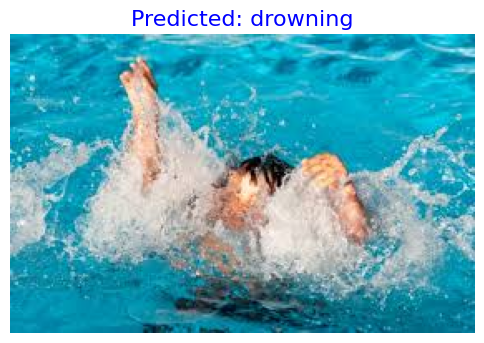

In [20]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Class label mapping
class_labels = {0: 'swimming', 1: 'tread_water', 2: 'drowning'}

# Load and preprocess the test image
image_path = "tester5.jpg"
image = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust to match your model's expected input size
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Match the normalization used during training
])

input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "C:/Users/hgtan/drowning_detection/kan_rgb_model.pth"

# Initialize model
model = KAN_RGB()
model.load_state_dict(torch.load(model_path, map_location=device))  # Load weights
model.to(device)
model.eval()  # Set model to evaluation mode

# Perform prediction
input_tensor = input_tensor.to(device)

with torch.no_grad():
    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()
    pred_label = class_labels.get(pred_class, "Unknown")

# Visualization with predicted label
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Predicted: {pred_label}", fontsize=16, color='blue')
plt.axis('off')
plt.show()

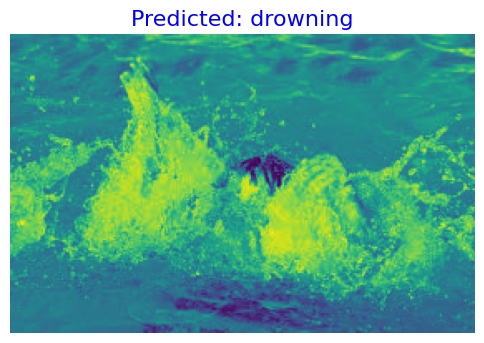

In [25]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Class label mapping
class_labels = {0: 'swimming', 1: 'tread_water', 2: 'drowning'}

# Load and preprocess the test image
image_path = "tester5.jpg"
image = Image.open(image_path).convert("L")

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust to match your model's expected input size
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Grayscale normalisation
])

input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "C:/Users/hgtan/drowning_detection/kan_grayscale_model.pth"

# Initialize model
model = KAN_Grayscale()
model.load_state_dict(torch.load(model_path, map_location=device))  # Load weights
model.to(device)
model.eval()  # Set model to evaluation mode

# Perform prediction
input_tensor = input_tensor.to(device)

with torch.no_grad():
    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()
    pred_label = class_labels.get(pred_class, "Unknown")

# Visualization with predicted label
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Predicted: {pred_label}", fontsize=16, color='blue')
plt.axis('off')
plt.show()

# Hyperparameter Tuning

In [4]:
NUM_CLASSES = 3
INPUT_CHANNELS = 3
IMAGE_SIZE = 32

### Load Dataset

In [5]:
class DrowningDataset(Dataset):
    def __init__(self, csv_file, split, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations = self.annotations[self.annotations['file_path'].str.contains(rf'\\{split}\\|/{split}/', regex=True)]
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = self.annotations.iloc[index, 0]

        # Use PIL to open image
        image = Image.open(img_path).convert("RGB")  
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return image, y_label

In [6]:
# Define transformations for training with augmentations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define transformations for validation (no augmentations)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# --- DataLoader Function ---
def get_dataloaders(batch_size):
    train_ds = DrowningDataset(csv_file='drowning_dataset_32.csv', split='train', transform=train_transform)
    val_ds = DrowningDataset(csv_file='drowning_dataset_32.csv', split='val', transform=val_transform)

    # Filter out None samples if any image files were not found
    train_ds.annotations = train_ds.annotations.dropna()
    val_ds.annotations = val_ds.annotations.dropna()
    
    # Custom collate function to handle potential None values from getitem
    def collate_fn(batch):
        batch = list(filter(lambda x: x[0] is not None, batch))
        if not batch:
             return torch.Tensor(), torch.Tensor() # Return empty tensors if batch is empty
        return torch.utils.data.dataloader.default_collate(batch)

    train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    return train_loader, val_loader

### Define Model

In [7]:
class KKAN_RGB_Tune(nn.Module):
    def __init__(self, grid_s=5, spline_ord=3, kernel_s=5):
        super().__init__()
        padding_val = kernel_s // 2

        self.conv1 = KAN_Convolutional_Layer(in_channels=INPUT_CHANNELS,
            out_channels= 6,
            kernel_size= (kernel_s,kernel_s),
            grid_size = grid_s,
            spline_order = spline_ord,
            padding =(padding_val,padding_val)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        # Calculate dimension after conv1 and pool1
        conv1_out_dim = (IMAGE_SIZE + 2 * padding_val - kernel_s) // 1 + 1
        pool1_out_dim = conv1_out_dim // 2

        self.conv2 = KAN_Convolutional_Layer(in_channels=6,
            out_channels= 16,
            kernel_size = (kernel_s,kernel_s),
            grid_size = grid_s,
            spline_order = spline_ord,
            padding =(padding_val,padding_val)
        )
        # Calculate dimension after conv2 and pool2
        conv2_out_dim = (pool1_out_dim + 2 * padding_val - kernel_s) // 1 + 1
        pool2_out_dim = conv2_out_dim // 2
        fc1_in_features = 16 * pool2_out_dim * pool2_out_dim

        self.flat = nn.Flatten()
        self.kan1 = KANLinear(
            fc1_in_features,
            NUM_CLASSES,
            grid_size=grid_s,
            spline_order=spline_ord,
            # Other KANLinear params fixed for simplicity
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0,1],
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.pool1(x)
        
        x = self.flat(x)
        x = self.kan1(x)
        
        return x

### Train and Evaluate Function

In [8]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, device, num_epochs):
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        # Training loop (condensed)
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            if images is None or images.nelement() == 0: continue # Skip empty batches
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                if images is None or images.nelement() == 0: continue # Skip empty batches
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
        val_acc = 100 * val_correct / val_total if val_total > 0 else 0
        print(f"Epoch {epoch+1} Val Acc: {val_acc:.2f}%")
        best_val_acc = max(best_val_acc, val_acc)

    return best_val_acc

In [9]:
NUM_EPOCHS_TUNE = 3 # Reduce epochs for faster tuning trials
N_TRIALS = 10 # Number of Optuna trials to run

In [10]:
def objective_kan(trial: optuna.trial.Trial):
    # Suggest hyperparameters
    grid_s = trial.suggest_categorical("grid_size", [5, 10])
    spline_ord = trial.suggest_int("spline_order", 2, 3)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    kernel_s = trial.suggest_categorical("kernel_size", [3, 5])

    batch_size = 32 # fixed batch size due to hardware limitations

    # Get DataLoaders
    train_loader, val_loader = get_dataloaders(batch_size)

    # Create model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = KKAN_RGB_Tune(grid_s=grid_s, spline_ord=spline_ord, kernel_s=kernel_s).to(device)

    # Create optimizer
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    validation_accuracy = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, device, NUM_EPOCHS_TUNE)

    return validation_accuracy

In [11]:
study_kan = optuna.create_study(direction="maximize", study_name="kan_tuning")
study_kan.optimize(objective_kan, n_trials=N_TRIALS)

print("\n--- KAN Second Iterative Tuning Results ---")
print(f"Number of finished trials: {len(study_kan.trials)}")

best_trial_kan = study_kan.best_trial
print(f"Best trial value (Validation Accuracy): {best_trial_kan.value:.4f}%")
print("Best hyperparameters:")
for key, value in best_trial_kan.params.items():
    print(f"  {key}: {value}")

[I 2025-04-30 13:56:49,799] A new study created in memory with name: kan_tuning
Epoch 1/3 [Val]: 100%|██████████| 114/114 [01:46<00:00,  1.07it/s]


Epoch 1 Val Acc: 81.59%


Epoch 2/3 [Val]: 100%|██████████| 114/114 [02:08<00:00,  1.12s/it]


Epoch 2 Val Acc: 90.05%


Epoch 3/3 [Val]: 100%|██████████| 114/114 [02:07<00:00,  1.12s/it]
[I 2025-04-30 16:54:41,248] Trial 0 finished with value: 93.25594250967386 and parameters: {'grid_size': 10, 'spline_order': 2, 'lr': 0.004357564311566152, 'optimizer': 'SGD', 'kernel_size': 5}. Best is trial 0 with value: 93.25594250967386.


Epoch 3 Val Acc: 93.26%


Epoch 1/3 [Val]: 100%|██████████| 114/114 [01:24<00:00,  1.35it/s]


Epoch 1 Val Acc: 93.01%


Epoch 2/3 [Val]: 100%|██████████| 114/114 [01:21<00:00,  1.40it/s]


Epoch 2 Val Acc: 96.05%


Epoch 3/3 [Val]: 100%|██████████| 114/114 [01:24<00:00,  1.34it/s]
[I 2025-04-30 18:14:06,314] Trial 1 finished with value: 96.04754007739082 and parameters: {'grid_size': 5, 'spline_order': 2, 'lr': 0.0026231061874684215, 'optimizer': 'Adam', 'kernel_size': 5}. Best is trial 1 with value: 96.04754007739082.


Epoch 3 Val Acc: 95.94%


Epoch 1/3 [Val]: 100%|██████████| 114/114 [00:28<00:00,  4.03it/s]


Epoch 1 Val Acc: 46.68%


Epoch 2/3 [Val]: 100%|██████████| 114/114 [00:28<00:00,  4.04it/s]


Epoch 2 Val Acc: 49.42%


Epoch 3/3 [Val]: 100%|██████████| 114/114 [00:28<00:00,  3.99it/s]
[I 2025-04-30 18:28:08,334] Trial 2 finished with value: 50.442233278054175 and parameters: {'grid_size': 5, 'spline_order': 2, 'lr': 0.0001800032930639325, 'optimizer': 'SGD', 'kernel_size': 3}. Best is trial 1 with value: 96.04754007739082.


Epoch 3 Val Acc: 50.44%


Epoch 1/3 [Val]: 100%|██████████| 114/114 [01:46<00:00,  1.07it/s]


Epoch 1 Val Acc: 65.95%


Epoch 2/3 [Val]: 100%|██████████| 114/114 [01:46<00:00,  1.07it/s]


Epoch 2 Val Acc: 73.11%


Epoch 3/3 [Val]: 100%|██████████| 114/114 [01:46<00:00,  1.07it/s]
[I 2025-04-30 21:22:13,403] Trial 3 finished with value: 77.58430071862908 and parameters: {'grid_size': 10, 'spline_order': 2, 'lr': 0.0017178810627720004, 'optimizer': 'SGD', 'kernel_size': 5}. Best is trial 1 with value: 96.04754007739082.


Epoch 3 Val Acc: 77.58%


Epoch 1/3 [Val]: 100%|██████████| 114/114 [00:25<00:00,  4.46it/s]


Epoch 1 Val Acc: 93.03%


Epoch 2/3 [Val]: 100%|██████████| 114/114 [00:25<00:00,  4.39it/s]


Epoch 2 Val Acc: 95.19%


Epoch 3/3 [Val]: 100%|██████████| 114/114 [00:28<00:00,  3.98it/s]
[I 2025-04-30 21:35:11,860] Trial 4 finished with value: 95.19071310116087 and parameters: {'grid_size': 5, 'spline_order': 2, 'lr': 0.002439792961468249, 'optimizer': 'Adam', 'kernel_size': 3}. Best is trial 1 with value: 96.04754007739082.


Epoch 3 Val Acc: 94.83%


Epoch 1/3 [Val]: 100%|██████████| 114/114 [01:07<00:00,  1.68it/s]


Epoch 1 Val Acc: 74.71%


Epoch 2/3 [Val]: 100%|██████████| 114/114 [01:07<00:00,  1.68it/s]


Epoch 2 Val Acc: 86.40%


Epoch 3/3 [Val]: 100%|██████████| 114/114 [01:07<00:00,  1.68it/s]
[I 2025-04-30 22:42:52,878] Trial 5 finished with value: 90.60254284134881 and parameters: {'grid_size': 5, 'spline_order': 2, 'lr': 0.002242171259493186, 'optimizer': 'SGD', 'kernel_size': 5}. Best is trial 1 with value: 96.04754007739082.


Epoch 3 Val Acc: 90.60%


Epoch 1/3 [Val]: 100%|██████████| 114/114 [01:47<00:00,  1.07it/s]


Epoch 1 Val Acc: 89.22%


Epoch 2/3 [Val]: 100%|██████████| 114/114 [02:07<00:00,  1.12s/it]


Epoch 2 Val Acc: 93.06%


Epoch 3/3 [Val]: 100%|██████████| 114/114 [02:07<00:00,  1.12s/it]
[I 2025-05-01 01:49:10,608] Trial 6 finished with value: 94.63792150359315 and parameters: {'grid_size': 10, 'spline_order': 2, 'lr': 0.00041982844301579605, 'optimizer': 'Adam', 'kernel_size': 5}. Best is trial 1 with value: 96.04754007739082.


Epoch 3 Val Acc: 94.64%


Epoch 1/3 [Train]:   0%|          | 0/507 [00:08<?, ?it/s]
[W 2025-05-01 01:49:19,387] Trial 7 failed with parameters: {'grid_size': 10, 'spline_order': 3, 'lr': 0.0005297841215698575, 'optimizer': 'SGD', 'kernel_size': 5} because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 12.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 8.94 GiB is allocated by PyTorch, and 1.69 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)').
Traceback (most recent call last):
  File "C:\Users\hgtan\anaconda3\envs\drowningDetection\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\hgtan\AppD

OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 8.94 GiB is allocated by PyTorch, and 1.69 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Train Model Using Best Params

Best params combination: Trial 1 \
{'grid_size': 5, 'spline_order': 2, 'lr': 0.0026231061874684215, 'optimizer': 'Adam', 'kernel_size': 5}

In [8]:
grid_size = 5
spline_order = 2
lr = 0.0026231061874684215
optimizer = 'Adam'
kernel_size = 5
batch_size = 32 # fixed batch size due to hardware limitations

In [9]:
# See total number of params
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Get DataLoaders
train_loader, val_loader = get_dataloaders(batch_size)

# Move model to GPU (if available)
model = KKAN_RGB_Tune(grid_s=grid_size, spline_ord=spline_order, kernel_s=kernel_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Params start",count_parameters(model))

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
precisions = []
recalls = []
f1_scores = []

# Variables to track the best model
best_val_acc = 0.0
best_epoch = 0
best_metrics = {}

start = time.perf_counter()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(val_loader)):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())    # Store actual labels
            
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Normalize test loss
    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Compute precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # Store metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

    
    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_metrics = {
            "epoch": best_epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
        }

        torch.save(model.state_dict(), "fine_tuned_kan.pth")

total_time = time.perf_counter() - start

model.training_time = total_time/60 /num_epochs
print("\nTraining complete! ✅")
print(f"Total time (min) {total_time/60:.2f}",)
print("\nBest Model Summary:")
print(f"Epoch: {best_metrics['epoch']}")
print(f"Train Loss: {best_metrics['train_loss']:.4f}, Train Acc: {best_metrics['train_acc']:.2f}%")
print(f"Val Loss: {best_metrics['val_loss']:.4f}, Val Acc: {best_metrics['val_acc']:.2f}%")
print(f"Precision: {best_metrics['precision']:.2f}, Recall: {best_metrics['recall']:.2f}, F1 Score: {best_metrics['f1_score']:.2f}")

Params start 53298


100%|██████████| 114/114 [00:36<00:00,  3.10it/s]


Epoch [1/20] - Train Loss: 0.4256, Train Acc: 83.33%
Val loss: 0.1572, Val Acc: 94.94%, Precision: 0.95, Recall: 0.95, F1 Score: 0.95


100%|██████████| 114/114 [00:35<00:00,  3.21it/s]


Epoch [2/20] - Train Loss: 0.2512, Train Acc: 91.37%
Val loss: 0.1287, Val Acc: 95.61%, Precision: 0.96, Recall: 0.95, F1 Score: 0.95


100%|██████████| 114/114 [00:35<00:00,  3.22it/s]


Epoch [3/20] - Train Loss: 0.2260, Train Acc: 92.49%
Val loss: 0.1108, Val Acc: 96.08%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:42<00:00,  2.67it/s]


Epoch [4/20] - Train Loss: 0.2157, Train Acc: 92.78%
Val loss: 0.1036, Val Acc: 96.55%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:42<00:00,  2.69it/s]


Epoch [5/20] - Train Loss: 0.2042, Train Acc: 93.17%
Val loss: 0.1550, Val Acc: 94.89%, Precision: 0.95, Recall: 0.95, F1 Score: 0.95


100%|██████████| 114/114 [00:42<00:00,  2.65it/s]


Epoch [6/20] - Train Loss: 0.2094, Train Acc: 92.88%
Val loss: 0.1231, Val Acc: 96.05%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:42<00:00,  2.66it/s]


Epoch [7/20] - Train Loss: 0.1936, Train Acc: 93.58%
Val loss: 0.1167, Val Acc: 96.49%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:35<00:00,  3.20it/s]


Epoch [8/20] - Train Loss: 0.1937, Train Acc: 93.58%
Val loss: 0.0947, Val Acc: 97.24%, Precision: 0.97, Recall: 0.97, F1 Score: 0.97


100%|██████████| 114/114 [00:35<00:00,  3.19it/s]


Epoch [9/20] - Train Loss: 0.1868, Train Acc: 93.84%
Val loss: 0.1287, Val Acc: 95.91%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:35<00:00,  3.20it/s]


Epoch [10/20] - Train Loss: 0.1820, Train Acc: 93.84%
Val loss: 0.1023, Val Acc: 96.55%, Precision: 0.97, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:35<00:00,  3.22it/s]


Epoch [11/20] - Train Loss: 0.1792, Train Acc: 93.87%
Val loss: 0.0933, Val Acc: 97.01%, Precision: 0.97, Recall: 0.97, F1 Score: 0.97


100%|██████████| 114/114 [00:36<00:00,  3.10it/s]


Epoch [12/20] - Train Loss: 0.1809, Train Acc: 94.17%
Val loss: 0.1073, Val Acc: 96.41%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:36<00:00,  3.17it/s]


Epoch [13/20] - Train Loss: 0.1873, Train Acc: 93.89%
Val loss: 0.1148, Val Acc: 96.16%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:39<00:00,  2.90it/s]


Epoch [14/20] - Train Loss: 0.1695, Train Acc: 94.43%
Val loss: 0.0968, Val Acc: 97.04%, Precision: 0.97, Recall: 0.97, F1 Score: 0.97


100%|██████████| 114/114 [00:39<00:00,  2.90it/s]


Epoch [15/20] - Train Loss: 0.1813, Train Acc: 93.81%
Val loss: 0.1023, Val Acc: 96.49%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:43<00:00,  2.59it/s]


Epoch [16/20] - Train Loss: 0.1704, Train Acc: 94.42%
Val loss: 0.0992, Val Acc: 96.68%, Precision: 0.97, Recall: 0.97, F1 Score: 0.97


100%|██████████| 114/114 [00:36<00:00,  3.16it/s]


Epoch [17/20] - Train Loss: 0.1705, Train Acc: 94.50%
Val loss: 0.1140, Val Acc: 96.57%, Precision: 0.96, Recall: 0.97, F1 Score: 0.97


100%|██████████| 114/114 [00:36<00:00,  3.15it/s]


Epoch [18/20] - Train Loss: 0.1777, Train Acc: 94.02%
Val loss: 0.1174, Val Acc: 96.43%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:36<00:00,  3.17it/s]


Epoch [19/20] - Train Loss: 0.1667, Train Acc: 94.37%
Val loss: 0.0975, Val Acc: 96.93%, Precision: 0.97, Recall: 0.97, F1 Score: 0.97


100%|██████████| 114/114 [00:36<00:00,  3.14it/s]

Epoch [20/20] - Train Loss: 0.1711, Train Acc: 94.32%
Val loss: 0.0986, Val Acc: 97.13%, Precision: 0.97, Recall: 0.97, F1 Score: 0.97

Training complete! ✅
Total time (min) 206.17

Best Model Summary:
Epoch: 8
Train Loss: 0.1937, Train Acc: 93.58%
Val Loss: 0.0947, Val Acc: 97.24%
Precision: 0.97, Recall: 0.97, F1 Score: 0.97


In [10]:
# Save metrics to a CSV file
metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies,
    "precisions": precisions,
    "recalls": recalls,
    "f1_scores": f1_scores,
}
df = pd.DataFrame(metrics)
df.to_csv("fine_tuned_kan_training_metrics.csv", index=False)

print("Metrics saved as 'fine_tuned_kan_training_metrics.csv'")

Metrics saved as 'fine_tuned_kan_training_metrics.csv'
